#**IMPORTACIÓN DEL *DATASET* Y ACTUALIZACIÓN DE LIBRERÍA**#

En primer lugar, se realiza la conexión con Google Drive y se descomprime el archivo *zip*.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!unzip -n '/content/drive/MyDrive/RT-BENE.zip' >> /dev/null

Mounted at /content/drive


Se debe actualizar *tensorflow* a la versión 2.11.0 para poder utilizar el parámetro *apply_class_balancing* de la función de pérdidas *BinaryFocalCrossentropy*.\
Después de actualizar, **se debe reiniciar el entorno de ejecución**.

In [ ]:
import tensorflow as tf

if tf.__version__ != '2.11.0':
  !pip uninstall tensorflow
  !pip install tensorflow

Found existing installation: tensorflow 2.9.2
Uninstalling tensorflow-2.9.2:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.8/dist-packages/tensorflow-2.9.2.dist-info/*
    /usr/local/lib/python3.8/dist-packages/tensorflow/*
Proceed (Y/n)? Y
  Successfully uninstalled tensorflow-2.9.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 69.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 KB 40.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 55.5 MB/s eta 0:00:00
  Attempting unins

#**CÓDIGO GENERAL**#

Se importan todas las librerías necesarias.

In [ ]:
import os
import scipy
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.metrics import auc
from sklearn.utils import class_weight
from tensorflow.keras import optimizers
from tensorflow.keras import applications
from sklearn.metrics import confusion_matrix
from tensorflow.keras.losses import BinaryFocalCrossentropy
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import f1_score, accuracy_score, classification_report, auc, roc_curve
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, MaxPool2D, Input, Concatenate, RandomFlip, RandomRotation, RandomBrightness, GlobalAveragePooling2D

Se establece la ruta de las imágenes y se eliminan las columnas que no son necesarias.\
También se establecen las dimensiones de las imágenes (60x36x3) y se fija la semilla para permitir la reproducibilidad de los experimentos.

In [ ]:
path = "/content/RT-BENE/"
imgs_path = path + "images"
data = pd.read_csv(path + "blinks.csv", dtype = {'blink':'str'})
data.drop('blink_id', axis = 1, inplace = True)
data.drop('video', axis = 1, inplace = True)

left_eye_col = 'left_eye'
right_eye_col = 'right_eye'
y_col = 'blink'

batch_size = 128
img_width = 60
img_height = 36

seed = 43
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

input_shape = (img_width, img_height, 3)

Se llevan a cabo dos particiones del conjunto de datos. En la primera, que parte del conjunto de datos original, se separa un 70% para *train*.\
Del 30% restante, una mitad es para *validation* y la otra para *test*.

In [ ]:
train_data, test_data = train_test_split(data, test_size = 0.3, random_state = seed)
dev_data, test_data = train_test_split(test_data, test_size = 0.5, random_state = seed)

train_data = train_data.reset_index(drop = True)
dev_data = dev_data.reset_index(drop = True)
test_data = test_data.reset_index(drop = True)

test_labels = test_data['blink'].astype('int32')

Se puede observar que hay muchas menos imágenes de ojos cerrados que de ojos abiertos debido a la velocidad con la que se produce un parpadeo y a que la mayor parte del tiempo los ojos están abiertos.\
Esto produce un desbalanceo de datos, lo que puede llevar a un sesgo en las predicciones.

In [ ]:
data.groupby('blink').count()

,left_eye,right_eye
blink,,
0,102793,102793
1,4557,4557


A continuación, se define el generador *custom* que devuelve dos imágenes.\
Se ha dedidido añadir el parámetro *shuffle* a la función *generator* dado que no se quiere que  se mezclen las instancias en el generador de *test*, puesto que las etiquetas se obtendrán de la propia partición de *test* en lugar de *test_generator*.



In [ ]:
datagen = ImageDataGenerator(rescale = 1./255)

def generator(dataframe, shuffle):
  left_eye_generator = datagen.flow_from_dataframe(dataframe = dataframe,
                                                   directory = imgs_path,
                                                   target_size = (img_width, img_height),
                                                   x_col = left_eye_col,
                                                   y_col = y_col,
                                                   class_mode = "binary",
                                                   seed = seed,
                                                   shuffle = shuffle,
                                                   batch_size = batch_size)

  right_eye_generator = datagen.flow_from_dataframe(dataframe = dataframe,
                                                    directory = imgs_path,
                                                    target_size = (img_width, img_height),
                                                    x_col = right_eye_col,
                                                    y_col = y_col,
                                                    class_mode = "binary",
                                                    seed = seed,
                                                    shuffle = shuffle,
                                                    batch_size = batch_size)

  while True:
    left_eye = left_eye_generator.next()
    left_eye_image = left_eye[0]
    label = left_eye[1]
    right_eye = right_eye_generator.next()
    right_eye_image = right_eye[0]
    yield[left_eye_image, right_eye_image], label

Se crea el generador de imágenes para la fase entrenamiento (*train_generator*), que a su vez hará uso del generador de validación (*dev_generator*). Para la fase de prueba, se crea el generador *test_generator*.

In [ ]:
train_generator = generator(train_data, True)
dev_generator = generator(dev_data, True)
test_generator = generator(test_data, False)

Asimismo, se obtienen los pesos de cada clase (*blink=0* y *blink=1*) dado que, debido al desbalanceo del *dataset*, se tendrá en cuenta a la hora de entrenar en algún experimento.\
Se puede observar cómo se ha dado más peso a la clase *blink=1*, que es la que menor número de instancias posee.

In [ ]:
class_weights = dict(enumerate(class_weight.compute_class_weight(
    class_weight = "balanced",
    classes = np.unique(train_data['blink']),
    y = train_data['blink']
    )))

class_weights

{0: 0.5226751060721987, 1: 11.525306748466258}

Por último, se define la función para representar de manera gráfica el valor de la función de pérdidas en cada *epoch*.

In [ ]:
def plot_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Binary focal crossentropy')
    plt.plot(history.epoch, np.array(history.history['loss']), label='Train Loss')
    plt.legend()
    plt.ylim([0, max(history.history['loss'])])

#**RED NEURONAL CONVOLUCIONAL PARTIENDO DE CERO**#

##**DEFINICIÓN DE LA ARQUITECTURA**##

Dado que la entrada son dos imágenes, se crean dos capas de Input y se concatenan. \\
También se añaden al modelo varias capas de convolución y de *pooling*, así como una *flatten* y dos redes completamente conectadas, siendo la última de ellas de una única unidad puesto que se trata de un problema de clasificación binaria.

In [ ]:
left = Input(shape = input_shape)
right = Input(shape = input_shape)

merged = Concatenate(axis = 1)([left, right])
conv_1 = Conv2D(16, 3, activation = 'relu', input_shape = input_shape)(merged)
mp_1 = MaxPooling2D()(conv_1)
conv_2 = Conv2D(32, 3, activation = 'relu')(mp_1)
mp_2 = MaxPooling2D()(conv_2)
conv_3 = Conv2D(64, 3, activation = 'relu')(mp_2)
mp_3 = MaxPooling2D()(conv_3)
flatten = Flatten()(mp_3)
dense_1 = Dense(512, activation  = 'relu')(flatten)
output = Dense(1, activation = 'sigmoid')(dense_1)

model = Model(inputs = [left, right], outputs = output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 60, 36, 3)]  0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 60, 36, 3)]  0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 120, 36, 3)   0           ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 118, 34, 16)  448         ['concatenate[0][0]']        

También se puede representar de forma gráfica la arquitectura de la red:

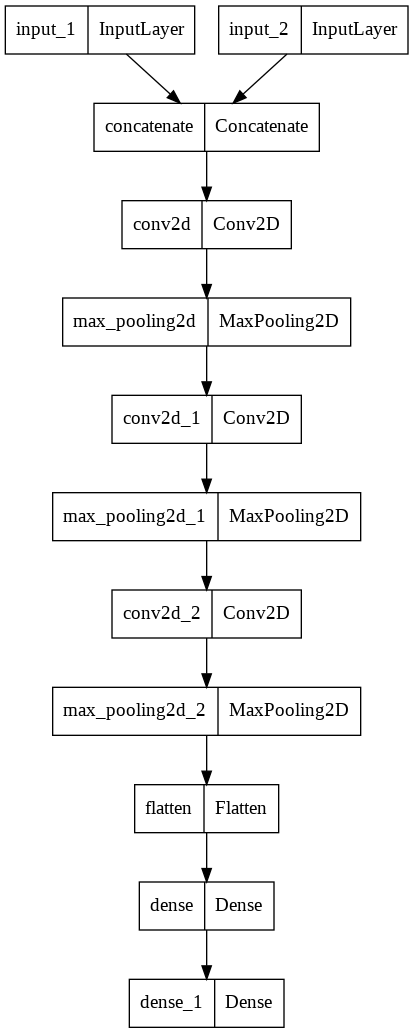

In [ ]:
tf.keras.utils.plot_model(model)

La función de pérdidas es *BinaryFocalCrossentropy*, la cual permite forzar el balanceo de clases. El valor del resto de sus hiperparámetros se mantienen por defecto.\
El optimizador es *Adam* y la tasa de aprendizaje es 0.001, y la métrica es *Accurary*. Una vez se tengan las predicciones, se calculará el valor de la métrica *F1-Score*.

In [ ]:
model.compile(loss = BinaryFocalCrossentropy(apply_class_balancing = True),
              optimizer = Adam(learning_rate = 0.001),
              metrics = ['Accuracy'])

##**ENTRENAMIENTO, EVALUACIÓN Y PREDICCIÓN**##

Se entrena el modelo final propuesto.

In [ ]:
history = model.fit(train_generator,
                    epochs = 3,
                    verbose = 1,
                    steps_per_epoch = len(train_data)/batch_size,
                    validation_data = dev_generator,
                    validation_steps = len(dev_data)/batch_size)

Found 75145 validated image filenames belonging to 2 classes.
Found 75145 validated image filenames belonging to 2 classes.
Epoch 1/3
588/587 [==============================] - ETA: 0s - loss: 0.0083 - Accuracy: 0.9697Found 16102 validated image filenames belonging to 2 classes.
Found 16102 validated image filenames belonging to 2 classes.
587/587 [==============================] - 438s 744ms/step - loss: 0.0083 - Accuracy: 0.9697 - val_loss: 0.0037 - val_Accuracy: 0.9825
Epoch 2/3
587/587 [==============================] - 420s 715ms/step - loss: 0.0035 - Accuracy: 0.9865 - val_loss: 0.0033 - val_Accuracy: 0.9907
Epoch 3/3
587/587 [==============================] - 365s 621ms/step - loss: 0.0028 - Accuracy: 0.9900 - val_loss: 0.0027 - val_Accuracy: 0.9915


In [ ]:
model.evaluate(test_generator,
               steps = len(test_data)/batch_size,
               verbose = 1)

Found 16103 validated image filenames belonging to 2 classes.
Found 16103 validated image filenames belonging to 2 classes.
125/125 [==============================] - 35s 279ms/step - loss: 0.0024 - Accuracy: 0.9940


[0.0024059349671006203, 0.9939762949943542]

Se vuelve a llamar al generador porque en el *evaluate* anterior ya se utilizó.\
Se realiza la predicción de las imágenes de *test*, y se obtiene un reporte con varias métricas, entre ellas *F1-Score*, cada una con sus diferentes *averages*.\
Por otro lado, se obtienen los valores de la matriz de confusión: *true negatives*, *false positives*, *false negatives* y *true positives*.

In [ ]:
test_generator = generator(test_data, False)
preds = model.predict(test_generator, steps = len(test_data)/batch_size).round().astype('int32')[:,0]

print("\n", classification_report(test_labels, preds, digits = 4))
tn, fp, fn, tp = confusion_matrix(test_labels, preds).ravel()
print("\nTN:", tn)
print("FP:", fp)
print("FN:", fn)
print("TP:", tp)

Found 16103 validated image filenames belonging to 2 classes.
Found 16103 validated image filenames belonging to 2 classes.
125/125 [==============================] - 26s 206ms/step

               precision    recall  f1-score   support

           0     0.9950    0.9987    0.9969     15468
           1     0.9654    0.8787    0.9200       635

    accuracy                         0.9940     16103
   macro avg     0.9802    0.9387    0.9585     16103
weighted avg     0.9939    0.9940    0.9938     16103


TN: 15448
FP: 20
FN: 77
TP: 558


##**GRÁFICAS**##

En la siguiente gráfica se puede ver el valor de la función de pérdidas en cada una de las tres *epoch*. Se puede ver que el error va disminuyendo según se van llevando a cabo más iteraciones de entrenamiento.

Máximo error: 0.008263032883405685
Mínimo error: 0.0027644913643598557


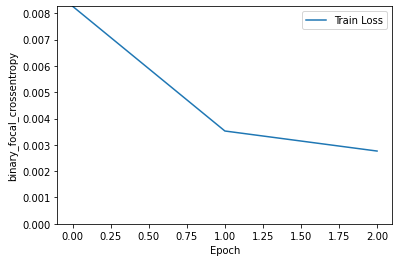

In [ ]:
print("Máximo error:", max(np.array(history.history['loss'])))
print("Mínimo error:", min(np.array(history.history['loss'])))
plot_history(history)

También se puede visualizar la curva ROC. La línea punteada representa un hipotético modelo donde la mitad de las instancias se clasifican correctamente, mientras que la azul representa el modelo entrenado.

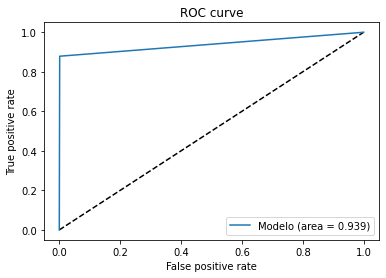

In [ ]:
fpr, tpr, thresholds_keras = roc_curve(test_labels, preds)
auc = auc(fpr, tpr)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Modelo (area = {:.3f})'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc = 'best')
plt.show()

#**RED NEURONAL CONVOLUCIONAL PARTIENDO DE UN MODELO PRE-ENTRENADO**#


##**DEFINICIÓN DE LA ARQUITECTURA**##

Se define la arquitectura para esta red neuronal convolucional.\
En primer lugar, se crean las dos capas de entrada, una por cada ojo del fotograma, y se concatenan. Seguidamente, se carga el modelo *DenseNet121* entrenado con *ImageNet* y se establece que el tensor de entrada sea la capa concatenada anterior. También se establece que las capas de este modelo pre-entrenado no se puedan entrenar.\
Por último, se crean nuevas capas para adaptar el modelo al problema de esta práctica y se crea el modelo final.

In [ ]:
left = Input(shape = input_shape)
right = Input(shape = input_shape)
merged = Concatenate(axis = 1)([left, right])

pretrained_model = applications.DenseNet121(weights = 'imagenet',
                                            include_top = False,
                                            input_tensor = merged)

for layer in pretrained_model.layers:
    layer.trainable = False

x = GlobalAveragePooling2D()(pretrained_model.output)
x = Dense(512, activation = 'relu')(x)
predictions = Dense(1, activation = 'sigmoid')(x)

model = Model(inputs = [left, right], outputs = predictions)
model.summary()

29084464/29084464 [==============================] - 2s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 60, 36, 3)]  0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 60, 36, 3)]  0           []                               
                                                                                                  
 concatenate_1 (Concatenate)    (None, 120, 36, 3)   0           ['input_3[0][0]',                
                                                                  'input_4[0][0]']                
                                                                                                  
 zero_padding2d (ZeroPaddin

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.781786 to fit



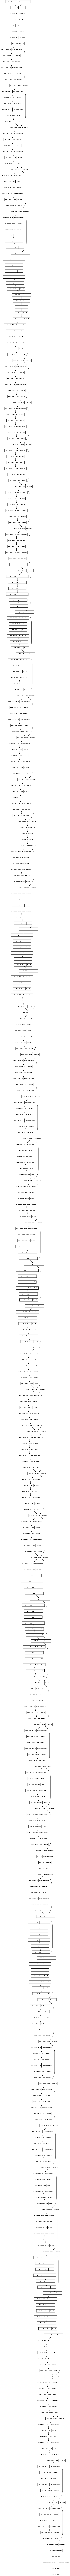

In [ ]:
tf.keras.utils.plot_model(model)

Al igual que en el anterior modelo propuesto, la función de pérdidas es *BinaryFocalCrossentropy*, aplicando balanceo de clases, y el optimizador es *Adam*, con tasa de aprendizaje de 0.001.

In [ ]:
model.compile(loss = BinaryFocalCrossentropy(apply_class_balancing = True),
              optimizer = Adam(learning_rate = 0.001),
              metrics = ['Accuracy'])

##**ENTRENAMIENTO, EVALUACIÓN Y PREDICCIÓN**##

Se entrena el modelo final propuesto.

In [ ]:
history = model.fit(train_generator,
                    epochs = 3,
                    verbose = 1,
                    steps_per_epoch = len(train_data)/batch_size,
                    validation_data = dev_generator,
                    validation_steps = len(dev_data)/batch_size)

Epoch 1/3
587/587 [==============================] - 1062s 2s/step - loss: 0.0065 - Accuracy: 0.9791 - val_loss: 0.0040 - val_Accuracy: 0.9823
Epoch 2/3
587/587 [==============================] - 1064s 2s/step - loss: 0.0039 - Accuracy: 0.9860 - val_loss: 0.0037 - val_Accuracy: 0.9852
Epoch 3/3
587/587 [==============================] - 1049s 2s/step - loss: 0.0030 - Accuracy: 0.9889 - val_loss: 0.0035 - val_Accuracy: 0.9907


In [ ]:
model.evaluate(test_generator,
               steps = len(test_data)/batch_size,
               verbose = 1)

Found 16103 validated image filenames belonging to 2 classes.
Found 16103 validated image filenames belonging to 2 classes.
125/125 [==============================] - 206s 2s/step - loss: 0.0033 - Accuracy: 0.9911


[0.003341271774843335, 0.9911196827888489]

In [ ]:
test_generator = generator(test_data, False)
preds = model.predict(test_generator, steps = len(test_data)/batch_size).round().astype('int32')[:,0]

print("\n", classification_report(test_labels, preds, digits = 4))
tn, fp, fn, tp = confusion_matrix(test_labels, preds).ravel()
print("\nTN:", tn)
print("FP:", fp)
print("FN:", fn)
print("TP:", tp)

Found 16103 validated image filenames belonging to 2 classes.
Found 16103 validated image filenames belonging to 2 classes.
125/125 [==============================] - 216s 2s/step

               precision    recall  f1-score   support

           0     0.9943    0.9964    0.9954     15468
           1     0.9086    0.8614    0.8844       635

    accuracy                         0.9911     16103
   macro avg     0.9515    0.9289    0.9399     16103
weighted avg     0.9909    0.9911    0.9910     16103


TN: 15413
FP: 55
FN: 88
TP: 547


##**GRÁFICAS**##

Máximo error: 0.006547633092850447
Mínimo error: 0.0029819386545568705


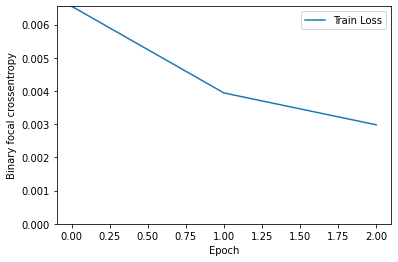

In [ ]:
print("Máximo error:", max(np.array(history.history['loss'])))
print("Mínimo error:", min(np.array(history.history['loss'])))
plot_history(history)

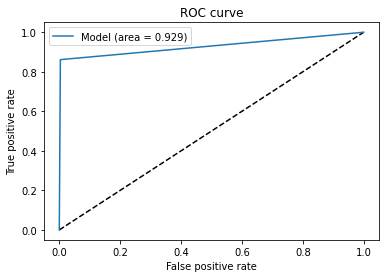

In [ ]:
fpr, tpr, thresholds_keras = roc_curve(test_labels, preds)
auc = metrics.auc(fpr, tpr)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label = 'Model (area = {:.3f})'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc = 'best')
plt.show()

#**CELDAS AUXILIARES**#

In [ ]:
#GUARDAR MODELO
from keras.models import model_from_json
model_json = model.to_json()
with open("model.json", "w") as json_file:
  json_file.write(model_json)
model.save_weights("model.h5")
print("Modelo guardado en el PC")

In [ ]:
#CARGAR MODELO
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights("model.h5")
print("Modelo cargado desde el PC")

In [ ]:
#OTRA FORMA DE HACER LAS PREDICCIONES
preds_1 = []
steps = len(test_data)/batch_size
aux = 0
test_generator = generator(test_data, False)

for data, label in test_generator:
  if aux < steps:
    for i in range(len(data[0])):
      left = tf.expand_dims(data[0][i], axis = 0)
      right = tf.expand_dims(data[1][i], axis = 0)
      preds_1.append(model.predict([left, right], verbose=0).round().astype('int32')[0][0])
    aux += 1
  else:
    break

print(classification_report(test_labels, preds_1))

f1 = f1_score(test_labels, preds_1, average = 'macro')
acc = accuracy_score(test_labels, preds_1)
print("f1-score: %.4f, accuracy: %.4f" % (f1, acc))